# MPC - CasADi
## Involve solving quadratic programs for the future time
https://web.casadi.org/

In [1]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

import copy, time

from casadi import *
from pylab import plot, step, figure, legend, show, spy

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

opts1 = {"expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.12


In [2]:
N = 100 # MPC steps
T0 = 0
Tf = 5 # MPC plan horizon
Ts = (Tf-T0)/N
Umax = 0.75
beta = 0.5  # nonlinear gain

Tfsim = 10
t_plan = np.linspace(0, Tf, N) # MPC plan time
delT_sim = Ts/2             # sim Ts
t_prop = np.array([0,delT_sim]) # prop time
Npts = Tfsim//delT_sim     # number of sim pts

Ruu = 1/20.0
Rzz = np.array([[10, 0],[0, 0.1]])   # performance variable penalty

In [3]:
def deriv(x,u,t):
    return vertcat(x[1], -x[0]-beta*x[0]**3 + u) 

def create_opti():
    opti = Opti() # Optimization problem

    # ---- decision variables ---------
    cX = opti.variable(2,N+1) # state trajectory
    cU = opti.variable(1,N)   # control trajectory (throttle)
    cx0 = cX[0,:]
    cx1 = cX[1,:]
    cUdiff = cU[0,:-1] - cU[0,1:]

    # ---- dynamic constraints - dx/dt = f(x,u)
    f = lambda x,u,t: deriv(x,u,t)

    dt = Tf/N # length of a control interval
    for k in range(N): # loop over control intervals
        # Runge-Kutta 4 integration
        k1 = f(cX[:,k],         cU[:,k],k*dt)
        k2 = f(cX[:,k]+dt/2*k1, cU[:,k],k*dt)
        k3 = f(cX[:,k]+dt/2*k2, cU[:,k],k*dt)
        k4 = f(cX[:,k]+dt*k3,   cU[:,k],k*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps

    # ---- boundary conditions --------
    p0 = opti.parameter()
    p1 = opti.parameter()
    opti.subject_to(cx0[0] == p0)   # start at position 0 ...
    opti.subject_to(cx1[0] == p1) # ... from stand-still 
    opti.subject_to(opti.bounded(-Umax,cU,Umax)) # control is limited

    # ---- objective          ---------
    opti.minimize(Rzz[0,0]*dot(cx0,cx0) + Rzz[1,1]*dot(cx1,cx1) + Ruu*dot(cUdiff,cUdiff)) 
    params = p0, p1, cU
    return opti, params 

def min_casadi(X0,Uold,opti,sol,params):
    if opti is None:
        #tic = time.time()
        opti, params = create_opti()
        p0, p1, cU = params
        opti.solver('ipopt',opts0) # set numerical backend
        #print(f"set up {time.time() - tic:.3f}")
    else:
        p0, p1, cU = params
        opti.set_initial(sol.value_variables())
        opti.solver('ipopt',opts1) # set numerical backend

    opti.set_value(p0,X0[0])
    opti.set_value(p1,X0[1])

    # ---- initial values for solver ---
    opti.set_initial(cU, Uold)
    #tic = time.time()
    sol = opti.solve()   # actual solve
    #print(f"compute {time.time() - tic:.3f}")
    sol.value
    return sol,opti,params #sol.value(cU), sol.value(cx0)[1], sol.stats()['success']

In [4]:
# ODE compute response to an input stream given by U
def fun(t,x,u):
    # dxdt = A@x + Bu*u(t)
    dxdt = np.array([x[1], -x[0]-beta*x[0]**3 + u(t)])
    return dxdt

In [5]:
x0 = np.array([2, 2])       # IC for sim
X = x0

opti = sol = p0 = p1 = cU = None
params = p0, p1, cU
Uold = [-1 for i in t_plan] 
Ustore = []
prev_time = time.time()
for k in np.arange(Npts):
    sol,opti,params = min_casadi(X,Uold,opti,sol,params)
    p0, p1, cU = params
    U = sol.value(cU)
    uprop = interp1d(x = t_prop, y = U[0:2], kind='zero')
    prop = solve_ivp(fun, [0, delT_sim], X, t_eval=t_prop, args=(uprop, ))
    Ustore = np.append(Ustore,sat(U[0]))
    Uold = np.append(U[1:],0) # shift and append guess of 0 to end   
    X = prop.y[:,-1]
    prev_time = time.time()

         but the previous value is set to disallow clobbering.
         The setting will remain as: "linear_solver ma27"
         but the previous value is set to disallow clobbering.
         The setting will remain as: "tol 0.001"


In [6]:
t_sim = np.linspace(0, Tfsim, int(Npts)) # MPC plan time
usim = interp1d(x = t_sim, y = Ustore, kind='zero')
sim = solve_ivp(fun, [0, Tfsim], x0, t_eval=t_sim, args=(usim, ))

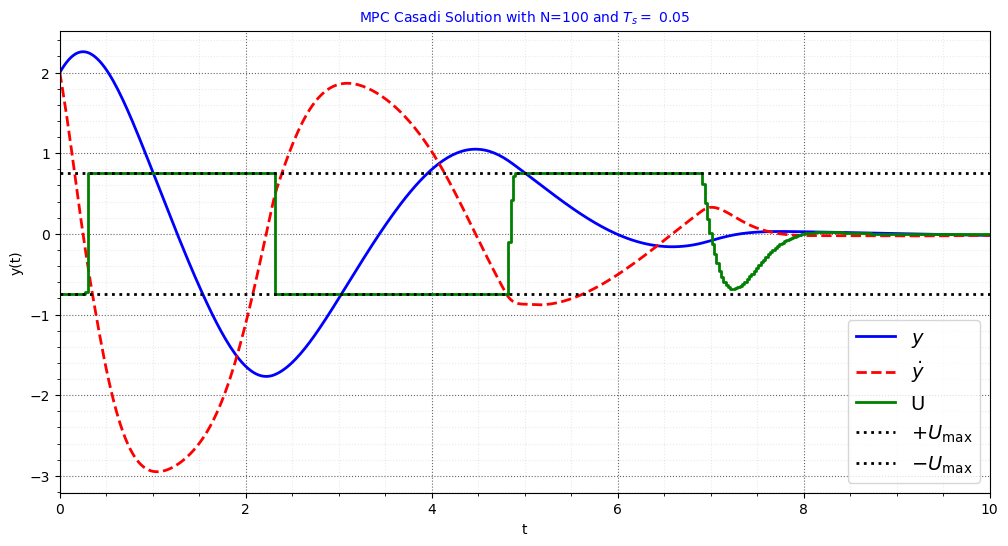

In [7]:
plt.figure(figsize = (12,6))
plt.plot(t_sim, sim.y[0,:],'b',label='$y$')
plt.plot(t_sim, sim.y[1,:],'r--',label='$\dot y$')
plt.step(t_sim,Ustore,'g',label='U',where='post')
plt.plot([0 ,max(t_sim)], [Umax, Umax],'k:',label='$+U_\max$')
plt.plot([0 ,max(t_sim)], [-Umax, -Umax],'k:',label='$-U_\max$')
plt.xlabel('t')
plt.legend()
plt.ylabel('y(t)')
plt.legend(fontsize=14)

plt.title('MPC Casadi Solution with N='+str(N)+' and $T_s=$ '+str(Ts))
plt.xlim([min(t_sim),max(t_sim)])
nicegrid()